<a href="https://colab.research.google.com/github/bronemos/ip-mnist-bbox/blob/main/Obrada_informacija_Laboratorijska_vje%C5%BEba_5_Neuronske_mre%C5%BEe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorijska vježba - Obrada informacija - Neuronske mreže

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchsummary
!pip install numpy matplotlib opencv-python

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 588.0MB 30kB/s 
     |████████████████████████████████| 12.5MB 249kB/s 
     |████████████████████████████████| 7.6MB 6.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


# Zadatak 1 - Klasifikacija slike rukom pisanih znamenki

U prvom zadatku ove laboratorijske vježbe želimo analizirati utjecaj arhitekture mreže i drugih hiperparametara na uspješnost predikcije. Vaš zadatak je složiti nekoliko modela različitih karakteristika, te će te te modele istrenirati na problemu klasifikacije rukom pisanih znamenki.

Veliki dio koda koji je potreban za provođenje vježbe je dan. Vi ćete riješiti zadatak nadopunjavanjem koda. Također ste slobodni izmjeniti predloženi kod, ali ne preporuča se. Za labos je potreban Python 3.6+ i PyTorch 1.6+.

## Učitavanje podataka

Sljedeći kod priprema MNIST Dataset objekte koji dolaze s PyTorch paketom. Također instanciramo i DataLoader objekte koji rukuju sa mješanjem i batchanjem skupa podataka.

In [ ]:
batch_size_train = 64
batch_size_test = 64

train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                      )


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                     )

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a)
Prikažite nekoliko primjera iz skupa za testiranje. Sliku pokažite pomoću `matplotlib` funkcije `imshow`. Neka `title` prikazane slike bude labela uzorka.

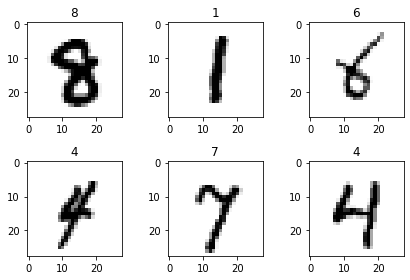

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # ---- 
    plt.title(int(example_targets[i]))
    plt.imshow(np.reshape(example_data[i], (28, 28)), cmap='gray_r')
    # ----

## Pomoćne metode za treniranje neuronskih mreža

Nakon podzadataka ove sekcije postoji skup testova na kojima možete provjeriti točnost vaših pomoćnih funkcija. Bez točno rješenih pomoćnih funkcija ostatak labosa ne možete riješiti. 

#### Podzadatak b) - Funkcija za određivanje broja parametara PyTorch modela

Jedna od metoda usporedbe naših modela će biti po broju parametara koji čine taj model. Radi toga je potrebno napisati metodu `get_number_of_model_parameters(model)` koja za predani model `model` vraća ukupni broj parametara tog modela.
Svaki PyTorch model sadrži implementaciju metode `.parameters()` koja vraća iterator nad parametrima modela. Ti parametri su tipa `torch.nn.parameter.Parameter`, čije dimenzije možemo dobiti pomoću `.shape` propertya.
Dovrište traženu metodu.

In [ ]:
def get_number_of_model_parameters(model):
    return len(list(model.parameters()))

#### Podzadatak c) - Funkcija za treniranje modela

Model se trenira u četiri koraka.

1. Izračuna se prolaz unaprijed nad jednim batchom.
2. Na temelju dobivenog izlaza i točnih labela se računa gubitak. Kako je pokazano u demonstracijskoj bilježnici, 
3. Izračunata greška se propagira unazad kroz mrežu radi računanja gradijenata.
4. Na temelju gradijenata, vrijednosti parametara i parametrima optimizatora (koji optimizator se koristi, kolika je stopa učenja, momentum i slično) se računa nova vrijednost parametara modela.

Implementirajte te korake u funkciji `train_step(train_loader, epoch, device, verbose)`.  

Napomene:
* Grešku koju trebate računati je "negative log likelihood loss", za koju PyTorch nudi implementaciju. Preporučamo da koristite gotovu implementaciju loss funkcije. 
* Računanje gradijenata pomoću propagacije greške u nazad se računa pomoću metode `.backward()`. Nad kojim elementom pozivamo tu metodu?
* Korak optimizacije se radi pomoću `.step()` metode optimizator objekta. Pretpostavite da postoji objekt `optimizer` u globalnom scopeu.
* Pripazite da Vam se gradijenti ne akumuliraju kroz više koraka optimizacije. PyTorch modeli nude metodu `.zero_grad()` koja postavlja vrijednosti svih gradijenata nekog modela na 0.


In [ ]:
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []
    
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # -------
        network.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # -----------
        
        if (batch_idx % log_interval == 0):
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item()))
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    return train_losses, train_counter

#### Podzadatak d) - Funkcija za evaluaciju modela

Uspješnost učenja određujemo pomoću metrika točnosti. U ovoj laboratoriskoj vježbi pratimo dvije metrike - `negative log likelihood` i `accuracy`. Sa NLLLoss smo se već susreli; accuracy definiramo kao:

$ accuracy = \frac{\text{number of correctly classified samples}}{\text{total number of samples}} $

Nadopunite funkciju `test(network, test_loader, device, verbose)` tako da se model evaluira za navedene metrike.

U predloženom kodu se koristi `with torch.no_grad()`. Kako tijekom evaluacije ne mjenjamo parametre modela, gradijent nam nije potreban. Time ubrzavamo računanje (ne računa se gradijent), štedimo memoriju (izračunati gradijent se ne sprema) i spriječavamo buduće probleme (npr. ostanu gradijenti do sljedeće faze treniranja, gdje se gradijenti test seta iskoriste za učenje).

In [ ]:
def test(network, test_loader, device, verbose=True):
    network.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            # ----- 
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            # -------
            
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%)\n'.format(
            test_loss, 
            correct, 
            len(test_loader.dataset),
            accuracy))
    
    return test_loss, accuracy.item()

U sljedećoj fazi laboratorijske vježbe izvršavamo eksperimente, spremamo rezultate i uspoređujemo. Rezultate ćemo spremati u mapi `results`, tako da će `key` mape biti naziv eksperimenta, a vrijednost će biti `tuple` koji sadrži vrijednosti po kojima se model uspoređuje.

In [ ]:
results = dict()

#### Podzadatak e) - Funkcija za provođenje cijelokupnog eksperimenta nad jednim modelom

Sada je vrijeme da se koraci iz prethodnih podzadataka objedine. Funkcija `train_network(network, train_loader, test_loader, device)` radi po sljedećem principu:

* Pretpostavlja se da u globalnom scopeu postoji varijabla imena `n_epochs` koja nam govori koliko epoha će se eksperiment izvršavati
* Liste `train_losses` i `test_losses` skupljaju loss vrijednosti tijekom treniranja, dok `train_counter` i `test_counter` skupljaju trenutke u kojima se metrika zabilježila (drugim riječima, to su X i Y os na grafu "loss po vremenu") 
* prije samog treniranja se vrši testiranje modela, da se utvrdi performansa slučajnog modela
* U svakoj epohi se model trenira, testira i rezultati se zapisuju u odgovarajuće liste
* Funkcija vraća te liste na kraju

In [ ]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # -----
    test_loss, test_accuracy = test(network, test_loader, device)
    # -------------
    test_losses.append(test_loss)

    for epoch in range(1, n_epochs + 1):
        # ---- 
        new_train_losses, new_train_counter = train_step(network, train_loader, epoch, device)
        test_loss, test_accuracy = test(network, test_loader, device)
        # ---------
        
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses.append(test_loss)

    return train_losses, train_counter, test_losses, test_counter, test_accuracy

#### Testovi za utvrđivanje točnosti rada pomoćnih funkcija

Sljedeći kod služi kao pomoć za provjeru ispravnosti gore traženih pomoćnih funkcija. Generira se dataset u dva odvojena skupa, i cilj je naučiti model koji klasificira iz kojeg skupa točka dolazi. Prvo generiramo podatke i slažemo DataLoader:

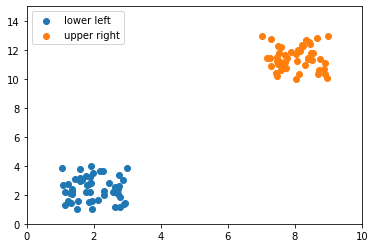

In [ ]:
data_x = np.hstack([np.random.uniform(1, 3, 50), np.random.uniform(7, 9, 50)])
data_y = np.hstack([np.random.uniform(1, 4, 50), np.random.uniform(10, 13, 50)])
labels = [0 if x < 50 else 1 for x in range(0, 100)]

for idx, unique_label in enumerate(["lower left", "upper right"]):
    if idx == 0:
        plt.scatter(data_x[0:50], data_y[0:50], label=unique_label)
    if idx == 1:
        plt.scatter(data_x[50:], data_y[50:], label=unique_label)
        
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 15)


tensor_x = torch.Tensor(np.dstack([data_x, data_y]).reshape(100, 2).astype(np.float32))
tensor_y = torch.Tensor(labels).to(dtype=torch.int64)

toy_dataset = TensorDataset(tensor_x, tensor_y)
toy_dataloader = DataLoader(toy_dataset, batch_size=1, shuffle=True)

Nakon toga definiramo naš model. U ovom slučaju je model dvoslojna mreža sa dva potpuno povezana sloja. 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

Podešavamo parametre koje naše pomoćne funkcije očekivaju, te instanciramo model i optimizator.

In [ ]:
n_epochs = 30
learning_rate = 0.01
log_interval = 33

network = Net().to('cpu')
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

I sada možemo trenirati naš model. Vaše funkcije su ispravne ako točnost doesgne 100% (ili barem jako blizu). **Bez ispravnih pomoćnih funkcija nećete moći riješiti ostatak labosa.**

In [ ]:
train_network(network, toy_dataloader, toy_dataloader, 'cpu')


Test set: Avg. loss: 0.7293, Accuracy:    50/  100 (50.00%)

Train Epoch:     1 [    0/  100 ( 0%)]	Loss: 0.999737
Train Epoch:     1 [   33/  100 (33%)]	Loss: 0.486055
Train Epoch:     1 [   66/  100 (66%)]	Loss: 0.949938
Train Epoch:     1 [   99/  100 (99%)]	Loss: 0.552742

Test set: Avg. loss: 0.7053, Accuracy:    50/  100 (50.00%)

Train Epoch:     2 [    0/  100 ( 0%)]	Loss: 0.549145
Train Epoch:     2 [   33/  100 (33%)]	Loss: 0.828833
Train Epoch:     2 [   66/  100 (66%)]	Loss: 0.803513
Train Epoch:     2 [   99/  100 (99%)]	Loss: 0.601875

Test set: Avg. loss: 0.6982, Accuracy:    50/  100 (50.00%)

Train Epoch:     3 [    0/  100 ( 0%)]	Loss: 0.798559
Train Epoch:     3 [   33/  100 (33%)]	Loss: 0.766533
Train Epoch:     3 [   66/  100 (66%)]	Loss: 0.789775
Train Epoch:     3 [   99/  100 (99%)]	Loss: 0.760465

Test set: Avg. loss: 0.6949, Accuracy:    50/  100 (50.00%)

Train Epoch:     4 [    0/  100 ( 0%)]	Loss: 0.635069
Train Epoch:     4 [   33/  100 (33%)]	Loss: 0.665

([0.9997372627258301,
  0.48605507612228394,
  0.9499378800392151,
  0.5527423024177551,
  0.5491448640823364,
  0.8288332223892212,
  0.8035131692886353,
  0.6018749475479126,
  0.7985589504241943,
  0.7665327787399292,
  0.7897753715515137,
  0.760465145111084,
  0.6350694894790649,
  0.6659209728240967,
  0.7583445310592651,
  0.7349541187286377,
  0.7295498251914978,
  0.6776561141014099,
  0.721390426158905,
  0.6731005311012268,
  0.6683129668235779,
  0.6325600147247314,
  0.6866515278816223,
  0.6866371035575867,
  0.7047120332717896,
  0.6526180505752563,
  0.6539294123649597,
  0.7022571563720703,
  0.697178840637207,
  0.7201072573661804,
  0.7197595834732056,
  0.7047046422958374,
  0.6996018886566162,
  0.7155224084854126,
  0.7059634923934937,
  0.6941179037094116,
  0.6971899271011353,
  0.7128833532333374,
  0.7191758155822754,
  0.6917440295219421,
  0.6995646953582764,
  0.7405942678451538,
  0.7426018714904785,
  0.6847022771835327,
  0.6797990798950195,
  0.68988806

## Provođenje eksperimenata i analiza rezultata

#### Podzadatak f) - Eksperimenti

Sljedeća faza labosa je korištenje naših funkcija u okviru eksperimenata. Potrebno je testirati sljedeće modele:

* **Plitki model sa uskim slojevima**
    * Model je plitak po tome što nema puno slojeva (ne ide u dubinu) i uzak po tome što sami slojevi nemaju veliki broj elemenata (npr. 1 sloj sa 100 neurona umjesto 10 slojeva sa 10 neurona)
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 20 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_narrow_{stopa učenja}`
* **Plitki model sa širokim slojevima**
    * Ovaj model također nema puno slojeva, ali ti slojevi imaju puno elemenata
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x40
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_wide_{stopa učenja}`
* **Duboki model sa uskim slojevima**
    * Ovaj model ima puno slojeva, ali su ti slojevi ograničeni u svojoj širini
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x20, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_narrow_{stopa učenja}`
* **Duboki model sa širokim slojevima**
    * Model koji ima sve komponente dobro (ili previše?) zastupljene.
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x32, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x64, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 50 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_wide_{stopa učenja}`


Implementirajte `.__init__(self)` i `.forward(self, x)` metode za svaki od opisanih modela, trenirajte ih, evaluirajte i spremite metrike. **Ponovite taj postupak za 3 različite stope učenja: 0.0000001, 0.01 i 1.**

Sve potrebne slojeve za ostvarenje navedenih modela možete pronaći u torch.nn modulu. Detalje možete pronaći u službenoj PyTorch dokumentaciji: https://pytorch.org/docs/stable/index.html 

**Spremite si najbolji model. Biti će potreban u podzadatku h)**.

Prvo je potrebno podesiti parametre. Parametri su sljedeći:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se dešava samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [ ]:
n_epochs = 3
learning_rate = 0.01
log_interval = 100
device = 'cuda'

Naš model definiramo u klasi "Net" koja nasljeđuje nn.Module. Nadjačajte metode `__init__(self)` i `forward(self, x)` kako je opisano u tekstu zadatka.

In [ ]:
class ShallowAndNarrow(nn.Module):
    def __init__(self):
        super(ShallowAndNarrow, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        # -------
        self.conv2 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.dropout = nn.Dropout()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(490, 20)
        self.fc2 = nn.Linear(20, 10)
        #-------------

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # ----
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # -----------
        return F.log_softmax(x, dim=1)

class ShallowAndWide(nn.Module):
    def __init__(self):
        super(ShallowAndWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # -------
        self.conv2 = nn.Conv2d(32, 40, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1440, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        #-------------

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # ----
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # -----------
        return F.log_softmax(x, dim=1)

class DeepAndNarrow(nn.Module):
    def __init__(self):
        super(DeepAndNarrow, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # -------
        self.conv2 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(180,64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        #-------------

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # ----
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # -----------
        return F.log_softmax(x, dim=1)

class DeepAndWide(nn.Module):
    def __init__(self):
        super(DeepAndWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # -------
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(576, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout = nn.Dropout()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        #-------------

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # ----
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # -----------
        return F.log_softmax(x, dim=1)

Da bi trenirali naš model, potrebno je napraviti instancu mreže i optimizatora. Koristite Stohastic Gradient Descent optimizator iz torch.optim modula. Detalji se mogu pronaći u službenoj dokuemntaciji PyTorcha za optim modul: https://pytorch.org/docs/stable/optim.html

In [ ]:
for learning_rate in (0.0000001, 0.01, 1):
  network1 = ShallowAndNarrow().to(device)
  print('-'*10, f'shallow_and_narrow_{learning_rate}', '-'*10, sep='\n')
  optimizer = torch.optim.SGD(network1.parameters(), lr=learning_rate)
  train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network1, train_loader, test_loader, device)
  number_of_parameters = get_number_of_model_parameters(network1)
  results[f'shallow_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

for learning_rate in (0.0000001, 0.01, 1):
  network2 = ShallowAndWide().to(device)
  print('-'*10, f'shallow_and_wide_{learning_rate}', '-'*10, sep='\n')
  optimizer = torch.optim.SGD(network2.parameters(), lr=learning_rate)
  train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network2, train_loader, test_loader, device)
  number_of_parameters = get_number_of_model_parameters(network2)
  results[f'shallow_and_wide_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

for learning_rate in (0.0000001, 0.01, 1):
  network3 = DeepAndNarrow().to(device)
  print('-'*10, f'deep_and_narrow_{learning_rate}', '-'*10, sep='\n')
  optimizer = torch.optim.SGD(network3.parameters(), lr=learning_rate)
  train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network3, train_loader, test_loader, device)
  number_of_parameters = get_number_of_model_parameters(network3)
  results[f'deep_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

for learning_rate in (0.0000001, 0.01, 1):
  network4 = DeepAndWide().to(device)
  print('-'*10, f'deep_and_wide_{learning_rate}', '-'*10, sep='\n')
  optimizer = torch.optim.SGD(network4.parameters(), lr=learning_rate)
  train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network4, train_loader, test_loader, device)
  number_of_parameters = get_number_of_model_parameters(network4)
  results[f'deep_and_wide_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)


----------
shallow_and_narrow_1e-07
----------

Test set: Avg. loss: 2.3213, Accuracy:   892/10000 (8.92%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.307589
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 2.333848
Train Epoch:     1 [12800/60000 (21%)]	Loss: 2.334797
Train Epoch:     1 [19200/60000 (32%)]	Loss: 2.328526
Train Epoch:     1 [25600/60000 (43%)]	Loss: 2.337704
Train Epoch:     1 [32000/60000 (53%)]	Loss: 2.293340
Train Epoch:     1 [38400/60000 (64%)]	Loss: 2.327162
Train Epoch:     1 [44800/60000 (75%)]	Loss: 2.327512
Train Epoch:     1 [51200/60000 (85%)]	Loss: 2.324917
Train Epoch:     1 [57600/60000 (96%)]	Loss: 2.369447

Test set: Avg. loss: 2.3212, Accuracy:   892/10000 (8.92%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 2.336722
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 2.315947
Train Epoch:     2 [12800/60000 (21%)]	Loss: 2.301582
Train Epoch:     2 [19200/60000 (32%)]	Loss: 2.331153
Train Epoch:     2 [25600/60000 (43%)]	Loss: 2.367838
Train Epoch:     2 [3

Iskoristimo našu pripremljenu funkciju za izvođenje eksperimenta:

Spremimo rezultate u mapu `results` kako je navedeno u zadatku. Također nam je potreban broj parametara mreže, što možemo izračunati u ovom koraku.

Prikažimo rezultate za ovaj eksperiment:

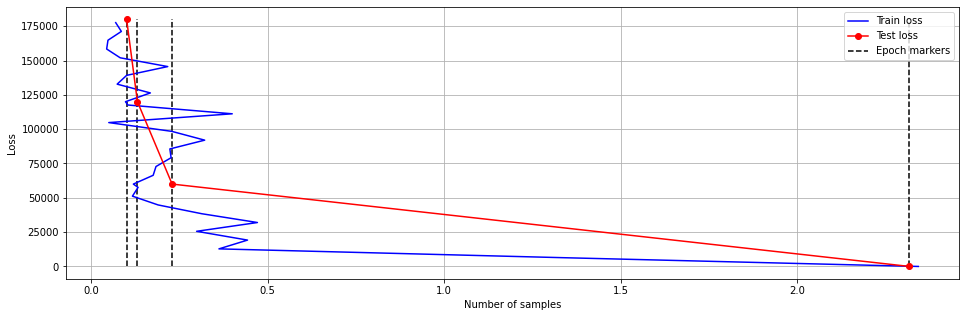

In [ ]:
train_losses, train_counter, test_losses, test_counter, test_accuracy, number_of_parameters = results['shallow_and_narrow_0.01']

fig = plt.figure(figsize=(16, 5))
plt.plot(train_counter, train_losses, color='blue', label='Train loss')
plt.plot(test_counter, test_losses, color='red',  marker='o', label='Test loss')
plt.vlines(test_counter, 0, max(train_losses + test_losses), linestyles='dashed', label='Epoch markers')

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

**Nadopunite bilježnicu sa svim traženim arhitekturama i learning rateovima zadanim u ovom podzadatku.** 

#### Podzadatak g) - Usporedba rezultata

Nakon što smo izvršili sve eksperimente potrebno ih je usporediti. Nacrtajte tražene grafove, te pomoću njih odgovorite na pitanja postavljena na Moodleu.

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **trening** skup podataka.

Odgovorite na sljedeća pitanja:
1. Radi li se o konzistentnom padu iz koraka u korak?
2. Jesu li neke arhitekture u startu značajno bolje od drugih?
3. Koji model je najnestabilniji tijekom treniranja?

Text(0.5, 0, 'Steps')

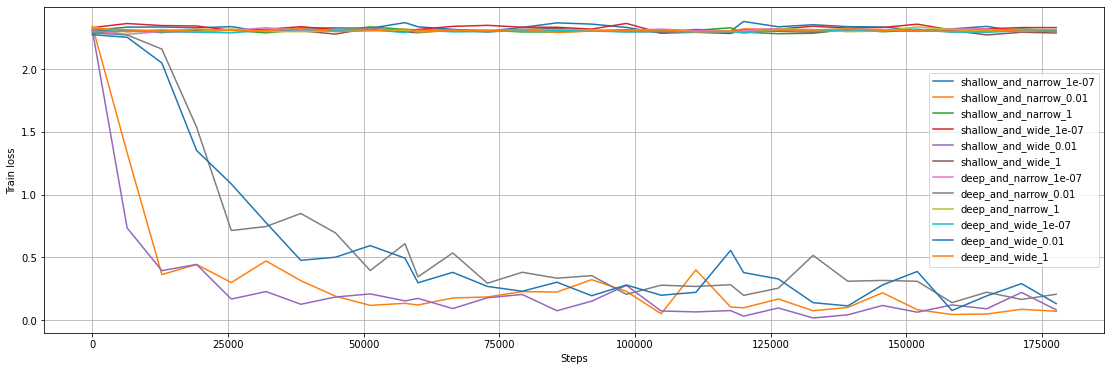

In [ ]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(train_counter, train_losses, label=model_key)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **test** skupu podataka.

Odgovorite na sljedeća pitanja:
4. Radi li se o konzistentnom padu iz koraka u korak?
5. Jesu li neke arhitekture u startu značajno bolje od drugih?

Text(0, 0.5, 'Steps')

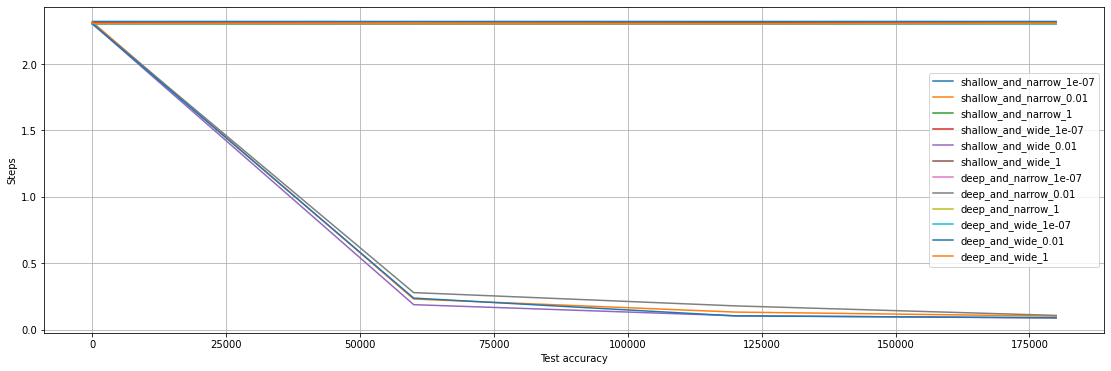

In [ ]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(test_counter, test_losses, label=model_key)

plt.legend()
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Test Loss")

Nacrtajte graf (scatter plot) gdje je X os broj parametara modela, a Y os je točnost koju model ostvaruje na test skupu.

Odgovorite na sljedeća pitanja:
6. Koji je najbolji model?
7. Kakvi su duboki modeli u usporedbu s plitkim modelima?
8. Kakvi su široki modeli u usporedbi s uskima?

Text(0.5, 0, 'Number of parameters')

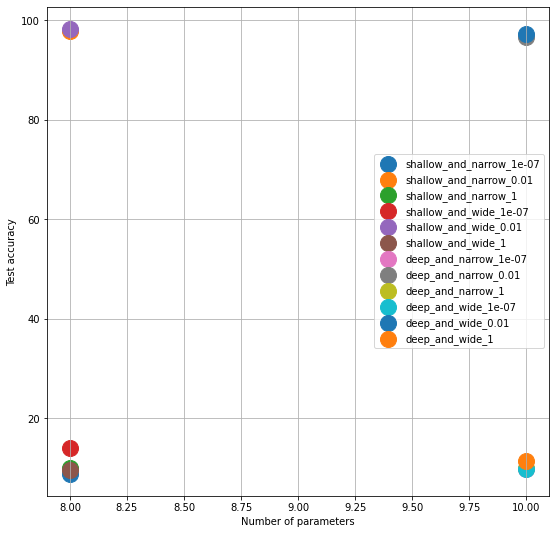

In [ ]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(number_of_parameters, test_accuracy, label=model_key, s=256)

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")

#### Podzadatak h) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: http://zver6.zesoi.fer.hr:18080/labos_oi/submission_z1.zip

Primjer filea kojeg treba generirati možete preuzeti sa: http://zver6.zesoi.fer.hr:18080/labos_oi/zad1_submission_sample.csv 

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

In [ ]:
best_net = ShallowAndWide().to(device)
optimizer = torch.optim.SGD(best_net.parameters(), lr=0.01)
train_network(best_net, train_loader, test_loader, device)


Test set: Avg. loss: 2.3000, Accuracy:   962/10000 (9.62%)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.302795
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 0.914801
Train Epoch:     1 [12800/60000 (21%)]	Loss: 0.352963
Train Epoch:     1 [19200/60000 (32%)]	Loss: 0.442292
Train Epoch:     1 [25600/60000 (43%)]	Loss: 0.338460
Train Epoch:     1 [32000/60000 (53%)]	Loss: 0.276666
Train Epoch:     1 [38400/60000 (64%)]	Loss: 0.152786
Train Epoch:     1 [44800/60000 (75%)]	Loss: 0.108139
Train Epoch:     1 [51200/60000 (85%)]	Loss: 0.376752
Train Epoch:     1 [57600/60000 (96%)]	Loss: 0.093949

Test set: Avg. loss: 0.1944, Accuracy:  9621/10000 (96.21%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 0.088595
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 0.172188
Train Epoch:     2 [12800/60000 (21%)]	Loss: 0.094340
Train Epoch:     2 [19200/60000 (32%)]	Loss: 0.035189
Train Epoch:     2 [25600/60000 (43%)]	Loss: 0.068671
Train Epoch:     2 [32000/60000 (53%)]	Loss: 0.097412
Train Epoch: 

([2.302795171737671,
  0.9148005843162537,
  0.3529626727104187,
  0.44229233264923096,
  0.33845967054367065,
  0.27666616439819336,
  0.15278559923171997,
  0.10813923925161362,
  0.3767521381378174,
  0.09394863992929459,
  0.08859466761350632,
  0.1721877008676529,
  0.09434008598327637,
  0.035189103335142136,
  0.06867127120494843,
  0.09741222858428955,
  0.12023226171731949,
  0.09992924332618713,
  0.06890943646430969,
  0.04931173846125603,
  0.0550142303109169,
  0.04509811848402023,
  0.22824184596538544,
  0.12001524865627289,
  0.07101530581712723,
  0.2127038836479187,
  0.03560400754213333,
  0.04067711532115936,
  0.16914872825145721,
  0.11222245544195175],
 [0,
  6400,
  12800,
  19200,
  25600,
  32000,
  38400,
  44800,
  51200,
  57600,
  60000,
  66400,
  72800,
  79200,
  85600,
  92000,
  98400,
  104800,
  111200,
  117600,
  120000,
  126400,
  132800,
  139200,
  145600,
  152000,
  158400,
  164800,
  171200,
  177600],
 [2.300029504776001,
  0.194440623307

In [ ]:
import os
import csv

data_path = './files/test_data'
file_names = sorted(os.listdir(data_path+'/images1'))[1:]
test_data = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(),
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
    )
test_data_loader = DataLoader(test_data, batch_size=128)

best_net.eval()
for data, _ in test_data_loader:
  data = data.to(device)
  out_data = [torch.argmax(tensor).item() for tensor in best_net.forward(data)]

with open('zad1.csv', 'w') as out_file:
  writer = csv.writer(out_file, delimiter=';')
  writer.writerow(['image_name', 'true_label'])
  for name, number in zip(file_names, out_data):
    writer.writerow([name, number])

## Zadatak 2 - Pronalazak znamenki na slici i klasifikacija pronađene znamenke 

Drugi zadatak je proširenje naučenog u prvom zadatku. Problem se proširuje - umjesto klasifikacije rukom pisane znamenke, naš problem je sada pronalazak rukom pisane znamenke na slici **i** klasifikacija.

Kao i u prethodnoj vježbi, dani su dijeli koda potrebnog za ostvarenje vježbe, a na Vama je da nadopunite dijelove koji nedostaju.

#### Skup podataka

Da bi mogli trenirati model za klasifikaciju i detekciju objekta na slici, moramo imati odgovarajući dataset. Koristimo postojeći MNIST dataset, a modificiramo ga tako da postavimo originalni MNIST uzorak na slučajnu poziciju na praznoj slici. Sljedeći kod generira takve uzorke, vraćajući modificiranu sliku, oznaku kategorije i poziciju znamenke na slici (*bounding box*).

In [ ]:
class PositionMNIST(Dataset):
    
    def __init__(self, image_size=128, transform=None, train_set=False):
        self.image_size = image_size
        self.transform = transform
        
        self.set = torchvision.datasets.MNIST('./files/', train=train_set, download=True)
        self.position_cache = [-1] * len(self.set)
    
    def __len__(self):
        return len(self.set)

    def __getitem__(self, idx):
        if self.position_cache[idx] == -1:
            x_pos = int(np.random.uniform(0, self.image_size-29))
            y_pos = int(np.random.uniform(0, self.image_size-29))
            self.position_cache[idx] = (x_pos, y_pos)
            
        x_pos, y_pos = self.position_cache[idx]
        
        canvas = np.zeros((self.image_size, self.image_size, 1), dtype=np.uint8)
        canvas[y_pos:(y_pos+28), x_pos:(x_pos+28), 0] = self.set[idx][0]
        
        x_pos = float(x_pos)
        y_pos = float(y_pos)
        
        if self.transform is not None:
            canvas = self.transform(canvas)
        
        return canvas, self.set[idx][1], (x_pos, y_pos, x_pos+28, y_pos+28)

In [ ]:
batch_size_train = 128
batch_size_test = 128
image_size = 128
mse_loss = nn.MSELoss(reduction='mean')

train_set = PositionMNIST(train_set=True, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

test_set = PositionMNIST(train_set=False, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw




Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a) - Vizualizacija podataka

Uzmite jedan uzorak pomoću data loadera i vizualizirajte ga. Neka u titleu piše klasa i lokacija.

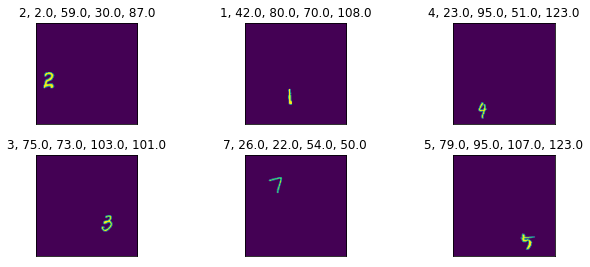

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_label, example_positions) = next(examples)
fig = plt.figure(figsize=(9, 4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # ----- OVO TREBA NADOPUNITI
    plt.imshow(example_data[i][0])
    plt.title(f"{example_label[i]}, {example_positions[0][i]}, {example_positions[1][i]}, {example_positions[2][i]}, {example_positions[3][i]}")
    # -----
    plt.xticks([])
    plt.yticks([])


#### Podzadatak b) - Pomoćne funkcije za treniranje

Nadopunite pomoćne funkcije za treniranje neuronskih mreža po principu naučenom u 1. zadatku. Temeljna razlika između pomoćne funkcije iz prethodnog zadatke i pomoćne funkcije u ovom zadatku je:

1. Rukovanje s podacima (ovdje ih ima više)
2. Drugi problem rješavamo, stoga trebamo drugačiju loss funkciju.

Loss funkcija će se u ovom slučaju sastojati od dva dijela - loss za klasifikaciju s kojim smo se već upoznali, i prosječan kvadrat greške (*mean squared error*) za određivanje pozicije. Loss će se računa kao:

$ \mathcal{L} = \text{NLLLoss}(\text{classification output}, \text{target)} + \frac{(x_1 - \hat{x}_1)^2 + (y_1 - \hat{y}_1)^2 + (x_2 - \hat{x}_2)^2 + (y_2 - \hat{y}_2)^2}{128 \cdot 128}  $

Pri čemu su $x$ i $y$ točne pozicije objekta na slici, a $\hat{x}$ i $\hat{y}$ su modelom određene pozicije objekta.


In [ ]:
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []
    
    network.train()
    
    for batch_idx, (data, target, position) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        x1, y1, x2, y2 = position
        x1 = x1.to(device)
        x2 = x2.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        
        # ----- 
        network.zero_grad()
        output_clsf, *output_position = network(data)
        loss = F.nll_loss(output_clsf, target) + (torch.mean(((x1 - output_position[0])**2 + (y1 - output_position[1])**2 + (x2 - output_position[2])**2 + (y2 - output_position[3])**2) / 128**2))
        loss.backward()
        optimizer.step()
        # -------
        
        if batch_idx % log_interval == 0:
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item()))
                
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
    return train_losses, train_counter

Po istom principu iz 1. zadatka nadopunite funkciju za evaluaciju modela. U ovom slučaju mjerimo 3 stvari: sam loss, točnost klasifikacije i posebno loss za detekciju.

In [ ]:
def test(network, test_loader, device, verbose=True):
    network.eval()
    
    test_loss_clsf = 0
    test_loss_bbox = 0
    correct = 0
    with torch.no_grad():
        for data, target, position in test_loader:
            data = data.to(device)
            target = target.to(device)
            x1, y1, x2, y2 = position
            x1 = x1.to(device)
            x2 = x2.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)

            # ---- 
            output_clsf, *output_position = network(data)
            test_loss_clsf += F.nll_loss(output_clsf, target, reduction='sum').item()
            test_loss_bbox += torch.mean(((x1 - output_position[0])**2 + (y1 - output_position[1])**2 + (x2 - output_position[2])**2 + (y2 - output_position[3])**2) / 128**2)
            pred = output_clsf.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            # ----------
            
    test_loss_clsf /= len(test_loader.dataset)
    test_loss_bbox /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    
    if verbose:
        print('\n[Test] Classification: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%) | Object detection: Avg. loss: {:.4f}\n'.format(
            test_loss_clsf, 
            correct, 
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset), 
            test_loss_bbox))
    
    return test_loss_clsf, test_accuracy, correct, test_loss_bbox

Pomoćna funkcija za provođene eksperimenata iz prethodnog zadatka je iskoristiva do na praćenje dodatnih metrika. Proširite tu funkciju za ovaj zadatak.

In [ ]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses_clsf = []
    test_accuracies = []
    test_losses_bbox = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # -----
    test_loss_clsf, test_accuracy, correct, test_loss_bbox = test(network, test_loader, device)
    test_losses_clsf.append(test_loss_clsf)
    test_losses_bbox.append(test_loss_bbox)
    # ----------

    for epoch in range(1, n_epochs + 1):
        # ---------
        new_train_losses, new_train_counter = train_step(network, train_loader, epoch, device)
        test_loss_clsf, test_accuracy, correct, test_loss_bbox = test(network, test_loader, device) 
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses_clsf.append(test_loss_clsf)
        test_losses_bbox.append(test_loss_bbox)
        # ---------
        
    # --------- 
    test_losses_total = test_losses_clsf + test_losses_bbox
    # -----------
    
    return train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter

## Provođenje eksperimenata i analiza rezultata

#### Podzadatak c) - Izrada modela koji točno klasificira i locira objekt na slici

Kao i u prethodnom zadatku, prvo je potrebno podesiti parametre. Parametri su isti, no ponovimo:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se dešava samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [ ]:
n_epochs = 3
learning_rate = 0.0005
momentum = 0.9
log_interval = 100
device = 'cuda'

Temeljna razlika u arhitekturi modela ovog zadatka i arhitekture modela iz prethodnog zadatka je broj izlaza. Prošla neuronska mreža je imala 10 izlaznih neurona - svaki za jednu klasu. Ova neuronska mreža ima 14 izlaza - 10 za svaku klasu za klasifikacijski problem i 4 za svaku koordinatu rezultirajućeg bounding boxa objekta.

Na temelju iskustva iz 1. zadatka, nadopunite sljedeći model da bi riješili problem:

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.image_size = image_size
        
        # --------
        # Ovdje je dan primjer jednog ulaznog conv sloja i oblika izlaznih slojeva za orijentaciju
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)

        self.conv2 = nn.Conv2d(64, 40, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(158760, 64)
        self.fc2 = nn.Linear(64, 512)
        self.fc3 = nn.Linear(512, 128)
        self.dropout = nn.Dropout()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.clsf_out = nn.Linear(128, 10)
        self.bbox_out = nn.Linear(128, 4)
      
        # --------

    def forward(self, x):
        # ---- ovdje nadopunite ostatak mreže
        x = F.relu(self.conv1(x), 2)
        # ----
        # dio mreže za klasifikaciju
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        # -------- izlaz za klasifikaciju
        clsf = F.log_softmax(self.clsf_out(x), dim=1)
        
        # dio mreže za bounding boxeve
        bbox = F.relu(self.bbox_out(x))

        # -------- izlaz za detekciju
        x1 = bbox[:, 0]
        y1 = bbox[:, 1]
        x2 = bbox[:, 2]
        y2 = bbox[:, 3]
        
        return clsf, x1.squeeze(), y1.squeeze(), x2.squeeze(), y2.squeeze()

In [ ]:
network = Net(image_size).to(device)
number_of_params = get_number_of_model_parameters(network)
print("Broj parametara u modelu:", number_of_params)

Broj parametara u modelu: 14


In [ ]:
network = Net(image_size).to(device)
optimizer = optim.AdamW(network.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [ ]:
train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter = train_network(network, train_loader, test_loader, device)


[Test] Classification: Avg. loss: 2.3030, Accuracy:   982/10000 (9.82%) | Object detection: Avg. loss: 0.0096

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 3.610107
Train Epoch:     1 [12800/60000 (21%)]	Loss: 2.290488
Train Epoch:     1 [25600/60000 (43%)]	Loss: 1.864851
Train Epoch:     1 [38400/60000 (64%)]	Loss: 1.720334
Train Epoch:     1 [51200/60000 (85%)]	Loss: 1.711510

[Test] Classification: Avg. loss: 1.6233, Accuracy:  3660/10000 (36.60%) | Object detection: Avg. loss: 0.0009

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 1.625696
Train Epoch:     2 [12800/60000 (21%)]	Loss: 1.549944
Train Epoch:     2 [25600/60000 (43%)]	Loss: 1.448847
Train Epoch:     2 [38400/60000 (64%)]	Loss: 1.149315
Train Epoch:     2 [51200/60000 (85%)]	Loss: 1.031540

[Test] Classification: Avg. loss: 0.8484, Accuracy:  6931/10000 (69.31%) | Object detection: Avg. loss: 0.0007

Train Epoch:     3 [    0/60000 ( 0%)]	Loss: 0.757515
Train Epoch:     3 [12800/60000 (21%)]	Loss: 0.607199
Train Epoch:  

**Vizualizacija metrika uspješnosti**

Vizualizirajte si sve metrike na sljedećem grafu: train_losses, test_losses_total, test_losses_clsf i test_losses_bbox. Pripazite što vam je na x osi!

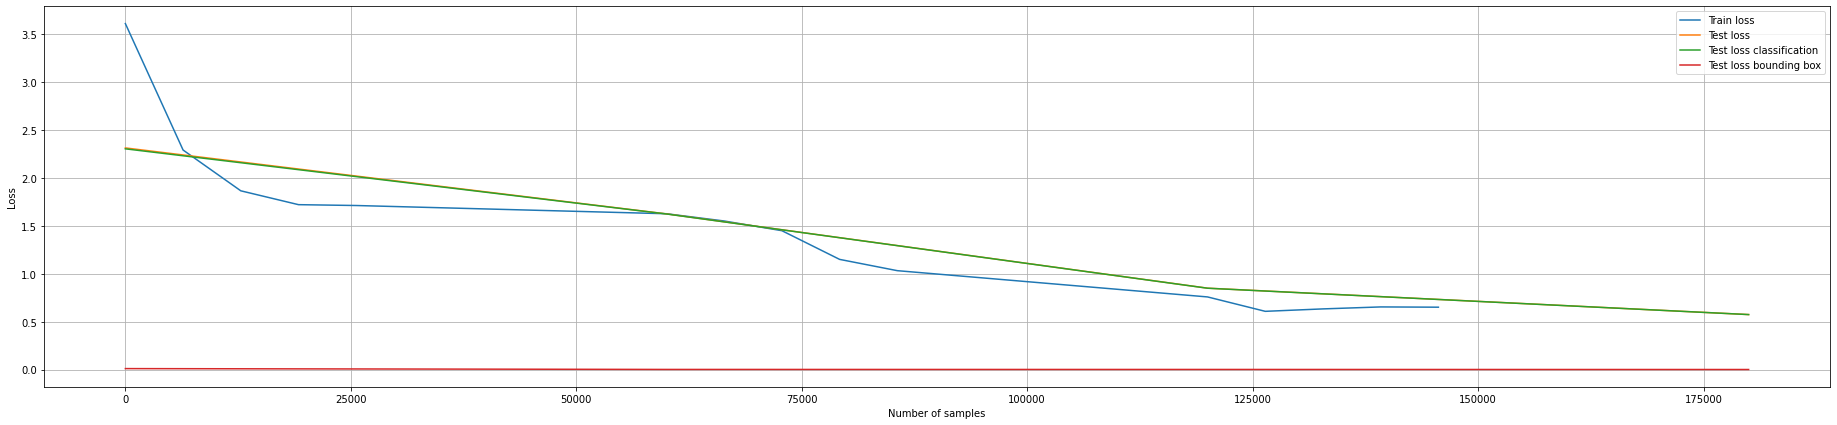

In [ ]:
test_losses_total = np.array(test_losses_clsf) + np.array(test_losses_bbox)

fig = plt.figure(figsize=(32, 7))
# ---- 
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot(test_counter, test_losses_total, label='Test loss')
plt.plot(test_counter, test_losses_clsf, label='Test loss classification')
plt.plot(test_counter, test_losses_bbox, label='Test loss bounding box')
# ----------

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

#### Vizualni pregled - što model estimira?

Iskorisite sljedeći kod da bi vidjeli kako izgledaju predikcije Vašeg modela.

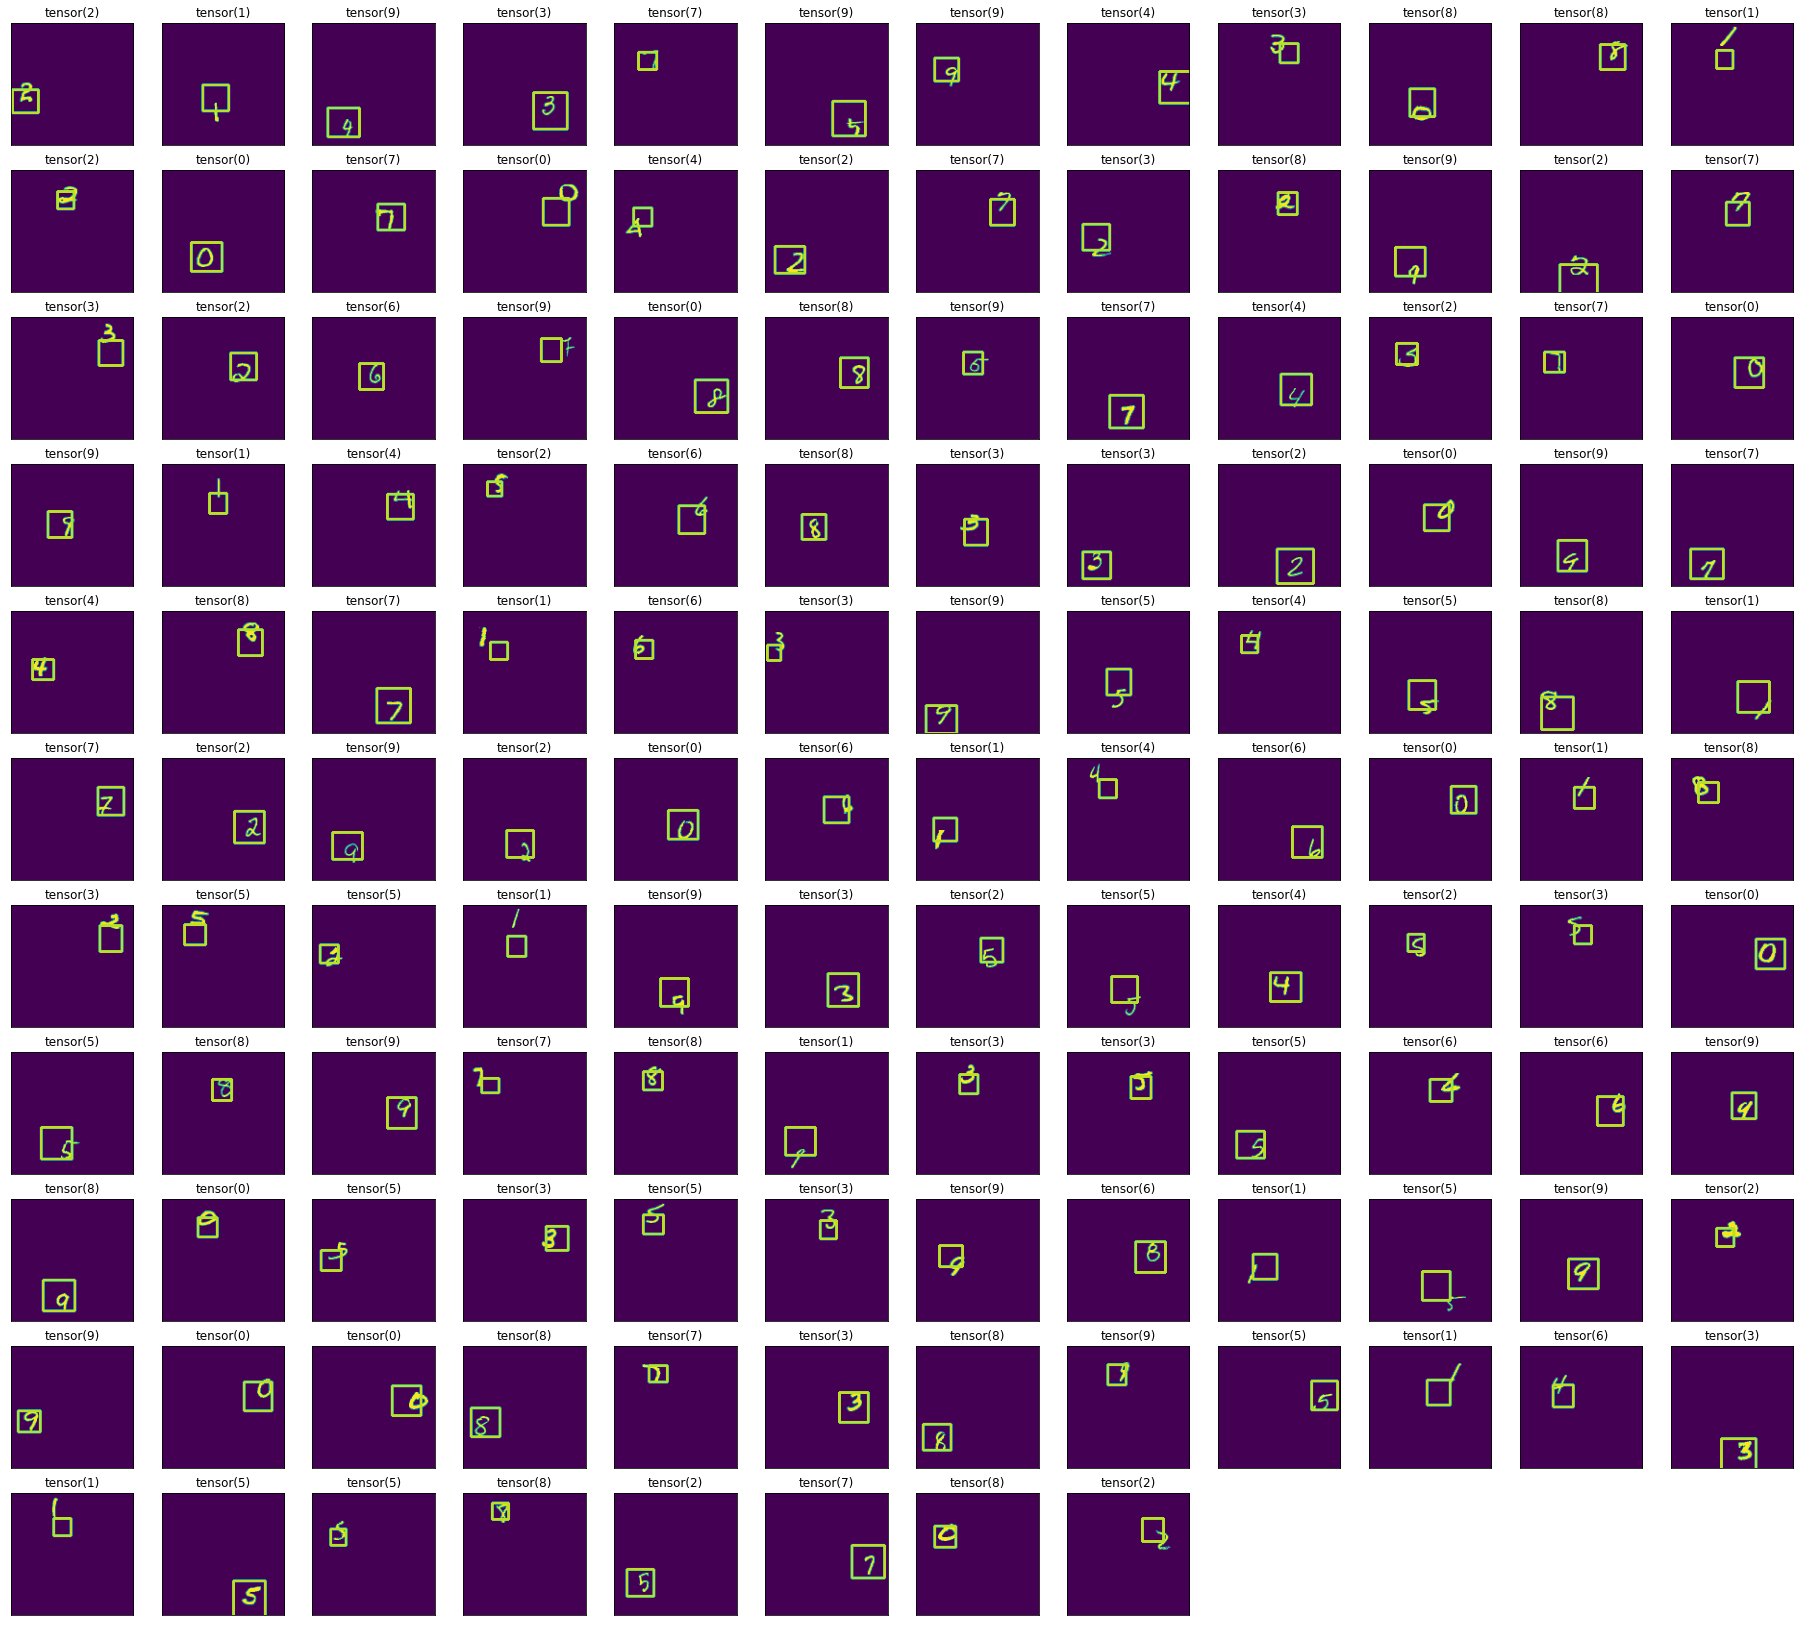

In [ ]:
with torch.no_grad():
    clsf_out, x1_out, y1_out, x2_out, y2_out = network.forward(example_data.to(device))

plt.figure(figsize=(32, 32))
for idx in range(0, example_data.shape[0]):
    image = np.array(example_data[idx, 0, ...]).copy()

    x1, y1, x2, y2 = list(map(lambda x: int(x.item()), [x1_out[idx, ...], y1_out[idx, ...], x2_out[idx, ...], y2_out[idx, ...]]))
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (2.5), 2)

    plt.subplot(12, 12, idx+1)
    plt.imshow(image)
    plt.title(np.argmax(clsf_out[idx, ...].cpu()))
    plt.xticks([])
    plt.yticks([])

#### Podzadatak d) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: http://zver6.zesoi.fer.hr:18080/labos_oi/submission_z2.zip

Primjer filea kojeg treba generirati možete preuzeti sa: http://zver6.zesoi.fer.hr:18080/labos_oi/zad2_submission_sample.csv 

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

In [ ]:
import os
import csv

data_path = './files/test_data'
file_names = sorted(os.listdir(data_path+'/images2'))[1:]
print(file_names)
print(len(file_names))
test_data = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(),
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
    )
test_data_loader = DataLoader(test_data, batch_size=128)

network.eval()
for data, _ in test_data_loader:
  data = data.to(device)
  clsf, x1, y1, x2, y2 = network.forward(data)
  clsf = [torch.argmax(tensor).item() for tensor in clsf]

with open('zad2.csv', 'w') as out_file:
  writer = csv.writer(out_file, delimiter=';')
  writer.writerow(['image_name', 'true_label', 'x1', 'y1', 'x2', 'y2'])
  for name, number, x1, y1, x2, y2 in zip(file_names, clsf, x1, y1, x2, y2):
    writer.writerow([name, number, x1.item(), y1.item(), x2.item(), y2.item()])